This Jupyter Notebook will provide machine learning algorithms with the provided model in order to predict career OPS.  In the MachineLearningStory OPS was predicted with R Squared results as high as .4970.  Let's get right into it.  The following provides all of the necessary libraries and functions.

In [52]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 18 12:31:14 2019

@author: Paul Scheibal
#
#  Used for Career OPS Predictions
#
#  This program runs a series of regression machine learning algorithms using the 
#  predictive model for baseball player performance prediction.  The models used are from 
#  sklearn machine learning library and are
#
#           Non-Linear Regression
#           Ridge Regression
#           XGBoost
#           Random Forests 
#           SVM
#           Lasso for viewing features and redundencies
# 
#
"""

import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab
import math
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from statsmodels.graphics.regressionplots import *
from scipy.stats import probplot
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
from IPython.core.pylabtools import figsize
import random
import warnings
warnings.filterwarnings("ignore")

figsize(14,10)
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style('white') 

# standard global constants
MIN_AT_BATS = 0
START_YEAR = 1960
END_YEAR = 2018
FSHZ = 17
START_DATE = datetime.strptime(str(START_YEAR)+'-01-01','%Y-%m-%d')
END_DATE = datetime.strptime(str(END_YEAR)+'-12-31','%Y-%m-%d')
LEGEND_PROPERTIES = {'weight':'bold'}

# general save file function
def save_stats_file(path, fn, df):
    stf = path + fn
    df.to_csv(stf, index=None, header=True)
    return True

# custom split into training and test sets where a player will belong to one and only one set (training or testing).
def split_players(df,pct):
    random.seed(63)
    players = np.array(df.playerID.drop_duplicates())
    plen = len(players)
    indlst = random.sample(range(0,plen), round(pct*plen))
    print('Number of Testing Players ' + str(round(plen*pct)))
    test_players = np.array(players[indlst])
    train_players = np.setdiff1d(players,test_players)
    return train_players, test_players

# custom split into training and test sets
def split_df(df,pct):
    train_p, test_p = split_players(df,pct)
    df_train = df[df.playerID.isin(train_p)]
    df_test = df[df.playerID.isin(test_p)]
    return df_train, df_test

# normalize numeric values if zeromean then use zero mean calc, otherwise use min/max calc
def normalize_values(X,cols,cn,type):
    if type == 'zeromean' :
        X[cn] = (X.loc[:,cols] - np.mean(X.loc[:,cols]))/ np.std(X.loc[:,cols])  
    else :
        X[cn] = (X.loc[:,cols] - np.min(X.loc[:,cols])) / ((np.max(X.loc[:,cols]))- np.min(X.loc[:,cols]))
    return X

# normalize categories (like Position)
def normalize_categories(X,cols,prefx):
    X_temp = X[cols]
    X = pd.get_dummies(X,columns=cols,prefix=prefx)
    X[cols] = X_temp
    return X

# custom calculation for R Squared, Adj R Squared, MSE, RMSE, FStatistic and others.  Same as what is supplied in python.
# I wanted to understand the calculations
def calc_regression_stats(X,y,yp):
    y = np.array(y)
    yp = np.array(yp)
    n = len(y)
    k = len(X.columns)
    yavg = sum(y)/n
    TSS = sum((y - yavg) ** 2)
    RSS = sum((y - yp) ** 2)
    Rsquared = 1 - (RSS/TSS)
    AdjRsquared = Rsquared - ((1-Rsquared) * ( k / ( n - k - 1 ) ) )
    MSE = RSS / n
    RMSE = np.sqrt(MSE)
    Fstatistic = ( Rsquared / (1 - Rsquared) ) * ( (n - k - 1 ) / k ) 
    error = ( (y - yp) / y ) * 100
    AbsErrorSum = sum(abs(error))
    MeanOfError = np.mean(error)
    StdOfError = np.std(error)
    return Rsquared, AdjRsquared, MSE, RMSE, Fstatistic, MeanOfError, StdOfError, AbsErrorSum

# various plots for assessing each machine learning run for each algorithm
def lr_results(df,X_test,y_test,y_pred,path,fn,stats_list,mdlinst):
    df_results = df.loc[y_test.index, :]
    df_results['predcOPS'] = y_pred
    df_results['error'] = 100 * ( ( df_results['cOPS'] - df_results['predcOPS'] ) / df_results['cOPS'])
    df_results['abserror'] = np.abs(100 * ( ( df_results['cOPS'] - df_results['predcOPS'] ) / df_results['cOPS']))
    #
    df_results['predcOPS'] = df_results['predcOPS']
    df_results['cOPS'] = df_results['cOPS']
    df_results['error'] = df_results['error']
    df_out = df_results[stats_list]
    save_stats_file(path,fn, df_out)
    #  calculate Rsquared, Adj Rsquared, MSE, RMSE and Fstatistic using my routine
    Rsquared, AdjRsquared, MSE, RMSE, Fstatistic, MeanOfError, StdOfError, AbsErrorSum = calc_regression_stats(X_test,y_test,y_pred)
    # print statistics
    print('R Squared: %1.4f' % Rsquared)
    print('Adjusted R Squared: %1.4f' % AdjRsquared)
    print('F Statistic: %1.4f' % Fstatistic)
    print('MSE: %1.4f' % MSE)
    print('RMSE: %1.4f' % RMSE)
    print('Test Observations:',format(len(y_test)))
    print('Sum of Abs Pct Error: %5.1f' % AbsErrorSum)
    print('Pct Mean Error: %1.4f' % MeanOfError)
    print('Pct Std Dev Error: %1.4f' % StdOfError)
    # print plots
    fig, ax = plt.subplots()
    ax.grid()
    acc = df_results.error
    ptile = np.percentile(acc,[15,85,2.5,97.5])
    sns.regplot(x=df_out['cOPS'], y=df_out['predcOPS'],
                line_kws={"color":"r","alpha":0.7,"lw":5},
                scatter_kws={"color":"b","s":8}
               )
    plt.title('Actual cOPS vs. Predicted cOPS',fontsize=16, weight='bold')
    plt.xlabel('Actual cOPS',fontsize=16, weight='bold')
    plt.ylabel('Predicted cOPS',fontsize=16, weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    fig, ax = plt.subplots()
    ax.grid()
    plt.hist(acc,bins=25)
    plt.title('Error : Actual cOPS - Predicted cOPS',fontsize=16, weight='bold')
    plt.xlabel('Error',fontsize=16, weight='bold')
    plt.ylabel('Frequency',fontsize=16, weight='bold')
    lab = 'Sampling Mean: %1.2f' % round(np.mean(df_out.error),2)
    lab1 = 'Conf Interval 15 ( %1.3f' % ptile[0] + ' )'
    lab2 = 'Conf Interval 85 ( %1.3f' % ptile[1] + ' )'
    lab3 = 'Conf Interval 2.5 ( %1.3f' % ptile[2] + ' )'
    lab4 = 'Conf Interval 97.5 ( %1.3f' % ptile[3] + ' )'
    plb.axvline(round(np.mean(df_out.error),2),label=lab, color='brown')
    plb.axvline(round(ptile[0],3), label=lab1, color='red')
    plb.axvline(round(ptile[1],3), label=lab2, color='red')
    plb.axvline(round(ptile[2],3), label=lab3, color='green')
    plb.axvline(round(ptile[3],3), label=lab4, color='green')
    leg=plt.legend(prop=dict(size=14))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    fig, ax = plt.subplots()
    ax.grid()
    # plot QQ Plot to see if normal
    probplot(acc,dist="norm",plot=plb)
    _ = plt.title('QQ Plot of OPS Data',weight='bold', size=16)
    _ = plt.ylabel('Ordered Values', labelpad=10, size=16, weight='bold')
    _ = plt.xlabel('Theoritical Quantiles', labelpad=10, size = 16, weight='bold')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
    plt.xticks(np.arange(-4,5,1))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plb.show()
    fig, ax = plt.subplots()
    ax.grid()
    plt.plot(y_pred, (y_pred-y_test), marker='.',linestyle='none',color='b')
    plt.title('Predicted cOPS vs. Residuals',fontsize=16, weight='bold')
    plt.xlabel('Predicted cOPS',fontsize=16, weight='bold')
    plt.ylabel('Residuals',fontsize=16, weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    return True


Next, the wrangled batting statistics file is read and the test/train players are set up.

In [53]:
# set path for reading Lahman baseball statistics and read data from rttm dataset
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'

battingf = path + 'dfbatting_player_stats_rttm_OPS.csv'
dfbatting_player_stats = pd.read_csv(battingf,parse_dates=['debut','finalGame','birthdate'])

dfbatting_player_stats = dfbatting_player_stats[(dfbatting_player_stats['debut'] >= START_DATE) &
                                                (dfbatting_player_stats['finalGame'] <= END_DATE)]
df = dfbatting_player_stats
df = df.reset_index(drop=True)
df = df[df['AB'] >= 300]
print(df.head(10))

# add decade
df['decade'] = (df['yearID'] // 10)*10

df = normalize_categories(df,['POS'],['POS']) 
df = normalize_values(df,['years_played','lag1_rtm_cAVG',  'lag1_rtm_AVG',  'lag1_cAVG',  'lag1_AVG', 'lag1_HR', 'lag1_cHR', 'lag1_rtm_HR', 'lag1_rtm_cHR', 'lag1_H', 'lag1_rtm_H', 'lag1_cH', 'lag1_rtm_cH', 'lag1_TB',  'lag1_cTB',  'lag1_AB',  'lag1_cAB', 'lag1_rtm_SLGTB', 'lag1_rtm_cSLGTB',  'lag1_rtm_SLGAB',  'lag1_rtm_cSLGAB', 'lag1_rtm_AB', 'lag1_rtm_cAB', 'decade',  'lag1_OPS', 'lag1_cOPS', 'lag1_OB', 'lag1_PA', 'lag1_OBP', 'lag1_cOBP', 'lag1_SLG', 'lag1_cSLG' ,'lag1_cOB',  'lag1_cPA', 'lag1_rtm_OB', 'lag1_rtm_PA', 'lag1_rtm_OPS', 'lag1_rtm_cOB', 'lag1_rtm_cPA', 'lag1_rtm_cOPS',  'age', 'height', 'weight', 'lag1_rtm_c1B', 'lag1_rtm_c2B', 'lag1_rtm_c3B', 'lag1_rtm_1B', 'lag1_rtm_2B', 'lag1_rtm_3B', 'lag1_c1B', 'lag1_c2B', 'lag1_c3B', 'lag1_1B', 'lag1_2B', 'lag1_3B', 'lag1_rtm_OBP', 'lag1_rtm_cOBP', 'lag1_rtm_SLG',  'lag1_rtm_cSLG'],
                         ['nyears_played','lag1_rtm_ncAVG', 'lag1_rtm_nAVG', 'lag1_ncAVG', 'lag1_nAVG','lag1_nHR','lag1_ncHR','lag1_rtm_nHR','lag1_rtm_ncHR','lag1_nH','lag1_rtm_nH','lag1_ncH','lag1_rtm_ncH','lag1_nTB', 'lag1_ncTB', 'lag1_nAB', 'lag1_ncAB','lag1_rtm_nSLGTB','lag1_rtm_ncSLGTB', 'lag1_rtm_nSLGAB', 'lag1_rtm_ncSLGAB','lag1_rtm_nAB','lag1_rtm_ncAB','ndecade', 'lag1_nOPS','lag1_ncOPS','lag1_nOB','lag1_nPA','lag1_nOBP','lag1_ncOBP','lag1_nSLG','lag1_ncSLG','lag1_ncOB', 'lag1_ncPA','lag1_rtm_nOB','lag1_rtm_nPA','lag1_rtm_nOPS','lag1_rtm_ncOB','lag1_rtm_ncPA','lag1_rtm_ncOPS', 'nage','nheight','nweight','lag1_rtm_nc1B','lag1_rtm_nc2B','lag1_rtm_nc3B','lag1_rtm_n1B','lag1_rtm_n2B','lag1_rtm_n3B','lag1_nc1B','lag1_nc2B','lag1_nc3B','lag1_n1B','lag1_n2B','lag1_n3B','lag1_rtm_nOBP','lag1_rtm_ncOBP','lag1_rtm_nSLG', 'lag1_rtm_ncSLG'],'zeromean')

# read team mapping and create a mapping function from string to integer
teamsf = path + 'teams_list.csv'
dfteams = pd.read_csv(teamsf)
teams_map = pd.Series(dfteams.index,index=dfteams.teamID).to_dict()
df.teamID = df.teamID.map(teams_map)

pct = 0.20

# custom train / test split on player boundaries.  IE, a player will belong to one and only one set (training or test)
# for a given run
df_train, df_test = split_df(df,pct)

print('Number of Training Records:',len(df_train))
df_test = df_test[ (df_test['OPS'] > .3) & (df_test['OPS'] < 1.2) & (df['AB'] >= 300) & (df['age'] >= 20) & (df['age'] <= 37)  ]
print('Number of Testing Records:',len(df_test))
# list of columns to output to file once run is completed.    
stats_list = ['yearID','playerID','playername','cOPS','predcOPS','error','AB','H','AVG','HR','3B','2B','1B','POS','age','height','lag1_rtm_OPS']
feature_list = ['lag1_ncHR','lag1_nHR','nage','nheight','ndecade','POS_1B','POS_2B','POS_3B','POS_SS','POS_OF','lag1_nSLG','lag1_ncSLG','lag1_nOBP','lag1_ncOBP','lag1_nOPS','lag1_ncOPS']

feature_list_rttm = ['lag1_rtm_ncHR','lag1_rtm_nHR','nage','nheight','POS_1B','POS_2B','POS_3B','POS_SS','POS_OF','ndecade','lag1_rtm_nSLG','lag1_rtm_ncSLG','lag1_rtm_nOBP','lag1_rtm_ncOBP','lag1_rtm_nOPS','lag1_rtm_ncOPS']
# setup training and testing sets
X_train = df_train[feature_list]
y_train = df_train.cOPS
X_test = df_test[feature_list]
y_test = df_test.cOPS  

   yearID   playerID    G   AB    H  2B  3B  HR  SF   BB  ...  lag1_cAVG  \
0    1995  abbotku01  120  420  107  18   7  17   5   36  ...   0.249275   
1    1996  abbotku01  109  320   81  18   7   8   0   22  ...   0.252288   
2    2002  abernbr01  117  463  112  18   4   2   2   25  ...   0.269737   
3    1999  abreubo01  152  546  183  35  11  20   4  109  ...   0.311871   
4    2000  abreubo01  154  576  182  42  10  25   3  100  ...   0.324065   
5    2001  abreubo01  162  588  170  48   4  31   9  106  ...   0.321186   
6    2002  abreubo01  157  572  176  50   6  20   6  104  ...   0.312642   
7    2003  abreubo01  158  577  173  35   1  20   7  109  ...   0.311623   
8    2004  abreubo01  159  574  173  47   1  30   7  127  ...   0.309595   
9    2005  abreubo01  162  588  168  37   1  24   8  117  ...   0.308397   

    cOB   cPA      cOBP    cH   cAB  cHR   cTB      cSLG      cOPS  
0   255   834  0.305755   193   765   26   326  0.426144  0.731899  
1   361  1179  0.306192  

XGBoost will be run predicting career OPS using the same features used to predict OPS.



XGBoost GridSearchCV


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   43.9s finished




Training Statistics: 


R Squared (training): 0.935
Adjusted R Squared (training): 0.935
Mean Squared Error (training): 0.000
Root Mean Squared Error (training): 0.020
F Statistic (training): 6990.882




Testing Statistics: 


R Squared: 0.9288
Adjusted R Squared: 0.9282
F Statistic: 1551.1300
MSE: 0.0005
RMSE: 0.0225
Test Observations: 1919
Sum of Abs Pct Error: 3896.0
Pct Mean Error: -0.0958
Pct Std Dev Error: 2.9900


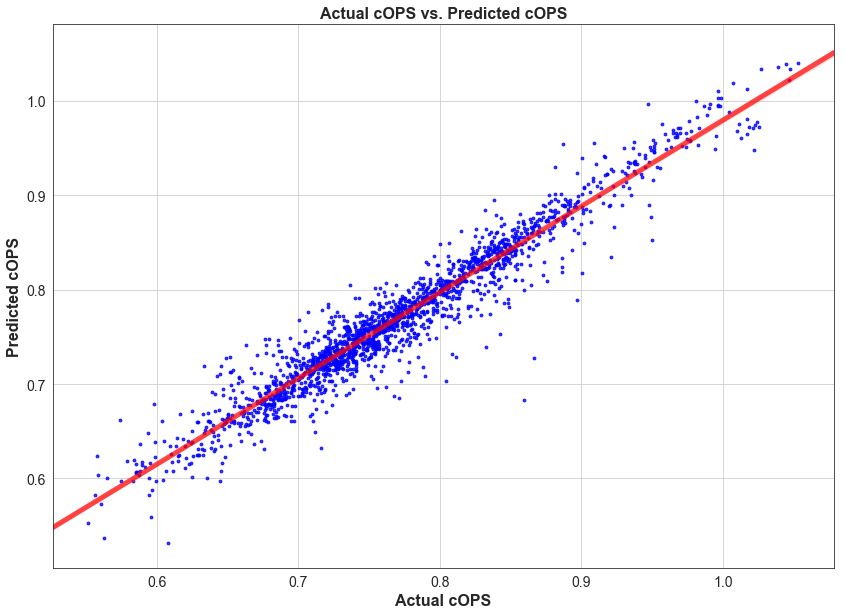

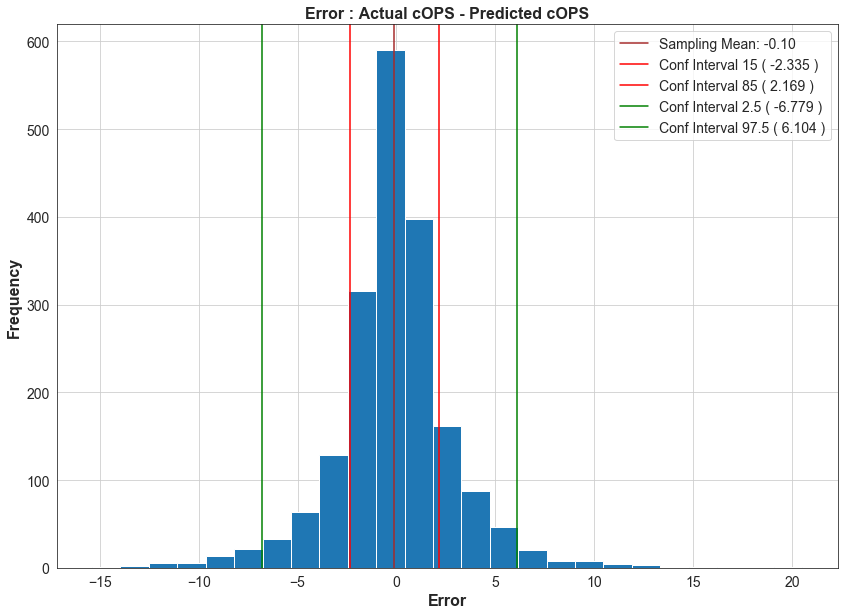

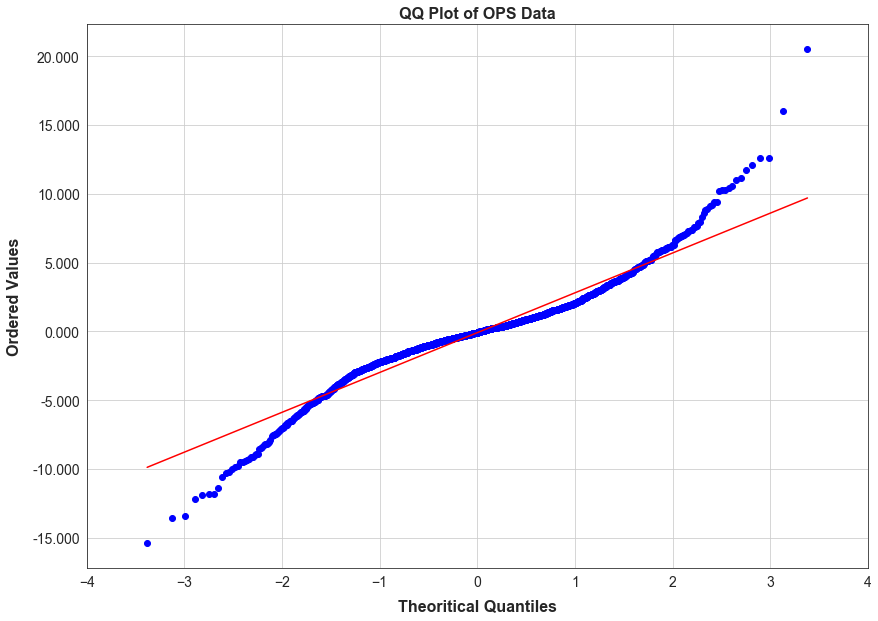

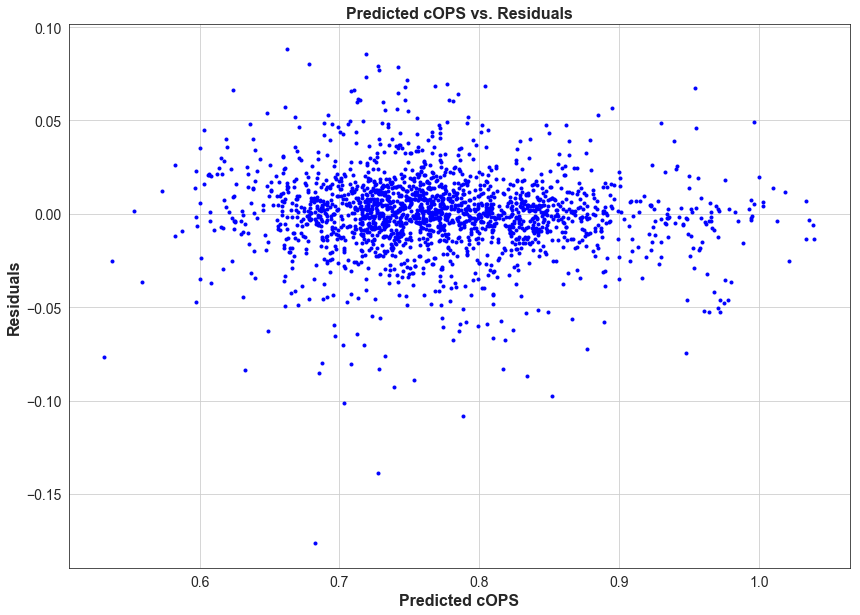

{'alpha': 0.01, 'colsample_bytree': 0.6, 'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsamples': 0.6}


In [54]:
    print('\n')
    print('XGBoost GridSearchCV')
    print('\n')
    params = {
                'colsample_bytree': [0.6],
                'learning_rate':[0.1],
                'n_estimators': [100,120],
                'max_depth':[3,4],
                'alpha':[0.01],
                'gamma':[0.001],
                'subsamples':[0.6]
            }
    reg_xgb = XGBRegressor(objective = 'reg:squarederror')    
    gs = GridSearchCV(estimator=reg_xgb,param_grid=params,cv=10,n_jobs = -1,verbose = 2)    
    gs.fit(X_train, y_train)    
    y_pred2 = gs.predict(X_train)   
    v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
    print('\n')
    print('Training Statistics: ')
    print('\n')
    print('R Squared (training): %1.3f' % v_Rsquared) 
    print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
    print('Mean Squared Error (training): %1.3f' % v_MSE)
    print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
    print('F Statistic (training): %1.3f' % v_Fstatistic)
    print('\n')
    
    print('\n')
    print('Testing Statistics: ')
    print('\n')
    y_pred = gs.predict(X_test)
    lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsXGB_GSc.csv',stats_list,gs) 
    print(gs.best_params_)

Ridge Regression is next.



Linear Regression - Ridge


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  40 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished




Training Statistics: 


R Squared (training): 0.912
Adjusted R Squared (training): 0.911
Mean Squared Error (training): 0.001
Root Mean Squared Error (training): 0.024
F Statistic (training): 4999.690




Testing Statistics: 


R Squared: 0.9242
Adjusted R Squared: 0.9236
F Statistic: 1449.8040
MSE: 0.0005
RMSE: 0.0232
Test Observations: 1919
Sum of Abs Pct Error: 4000.2
Pct Mean Error: -0.0086
Pct Std Dev Error: 3.0603


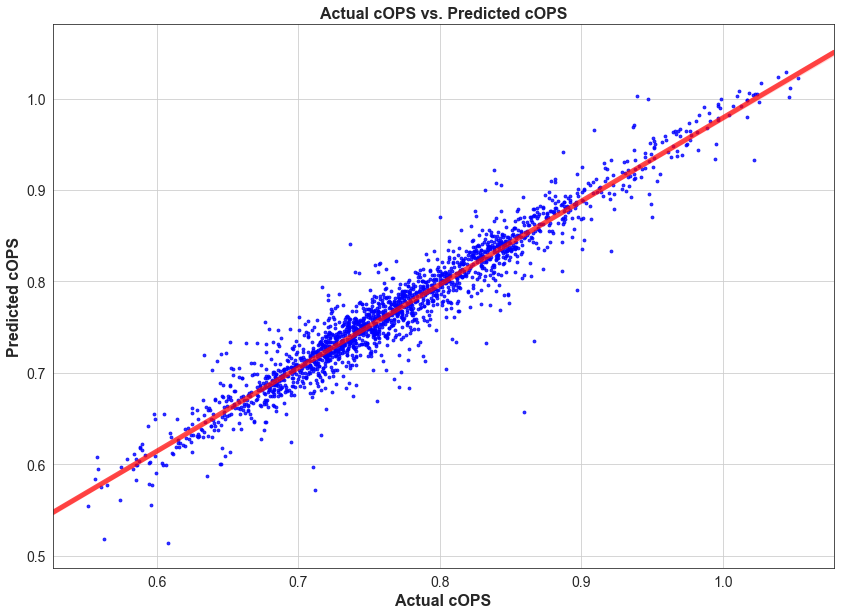

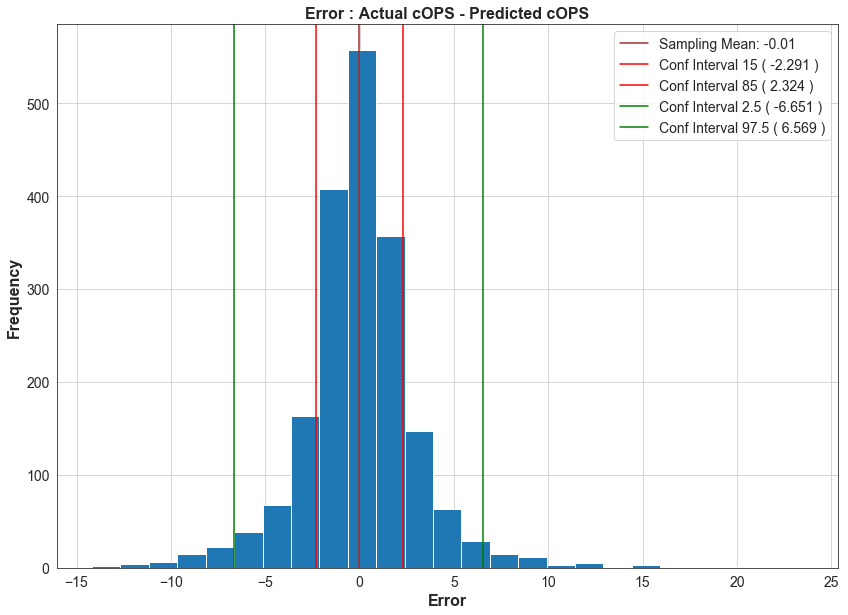

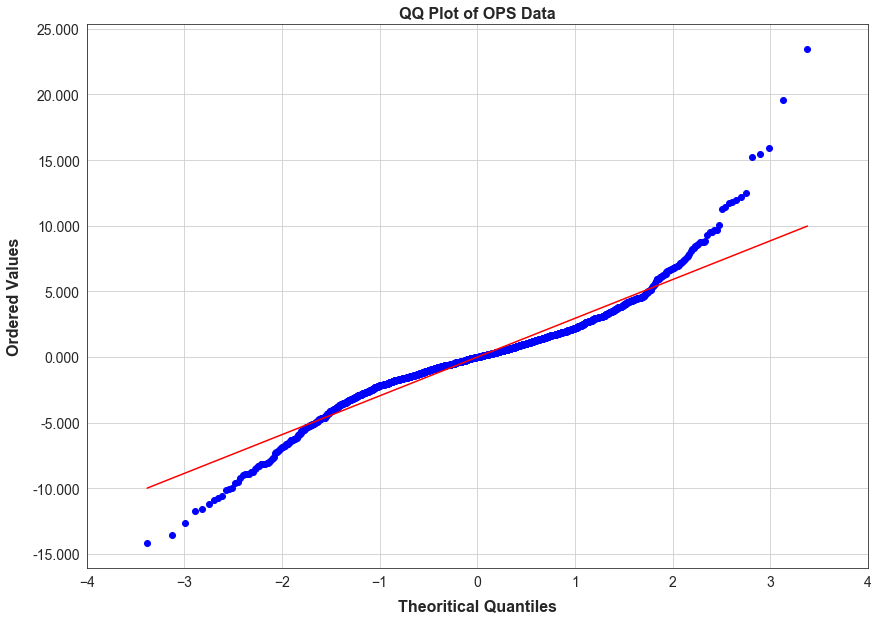

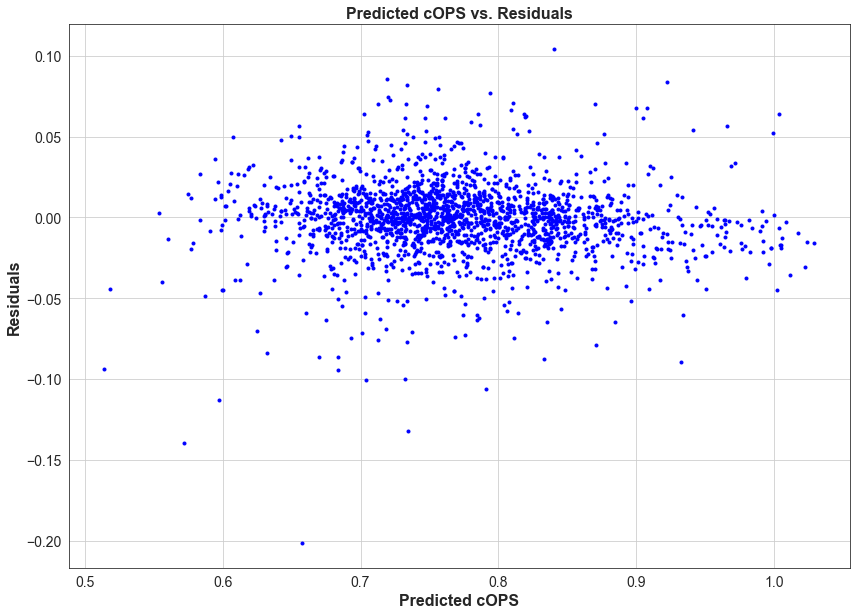

{'alpha': 0.001}


In [55]:
    print('\n')
    print('Linear Regression - Ridge')
    print('\n')
    params = {
                'alpha':[0.0001,0.001,0.1,0.1]
            }
    ridge = Ridge(normalize=True,random_state=61)
    gs = GridSearchCV(estimator=ridge,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
    gs.fit(X_train, y_train)    
    y_pred2 = gs.predict(X_train)   
    v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
    print('\n')
    print('Training Statistics: ')
    print('\n')
    print('R Squared (training): %1.3f' % v_Rsquared) 
    print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
    print('Mean Squared Error (training): %1.3f' % v_MSE)
    print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
    print('F Statistic (training): %1.3f' % v_Fstatistic)
    print('\n')
    
    print('\n')
    print('Testing Statistics: ')
    print('\n')
    y_pred = gs.predict(X_test)   
    lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsRidge_GSc.csv',stats_list,ridge)
    print(gs.best_params_)

Random Forests is next



Random Forest Regressor


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished




Training Statistics: 


R Squared (training): 0.950
Adjusted R Squared (training): 0.950
Mean Squared Error (training): 0.000
Root Mean Squared Error (training): 0.018
F Statistic (training): 9158.372




Testing Statistics: 


R Squared: 0.9257
Adjusted R Squared: 0.9251
F Statistic: 1481.2421
MSE: 0.0005
RMSE: 0.0230
Test Observations: 1919
Sum of Abs Pct Error: 3981.1
Pct Mean Error: -0.0330
Pct Std Dev Error: 3.0335


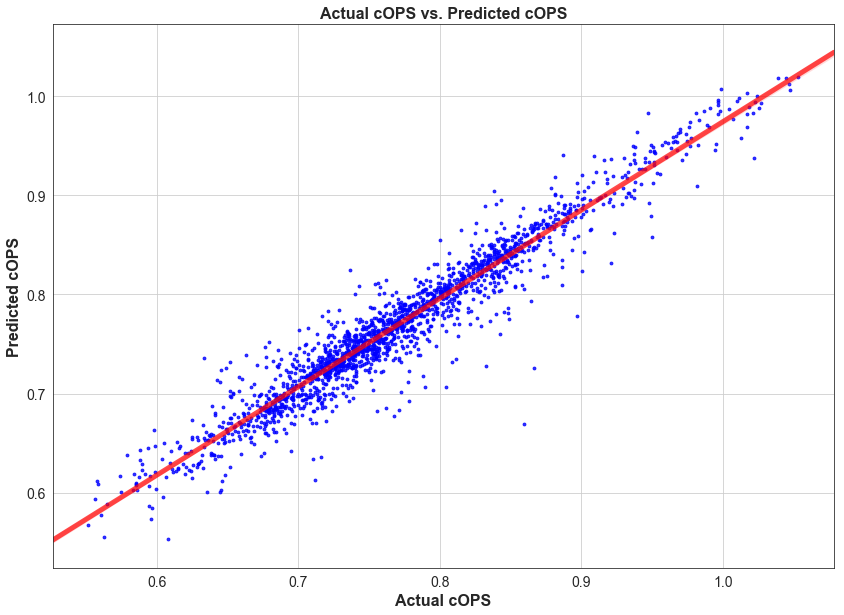

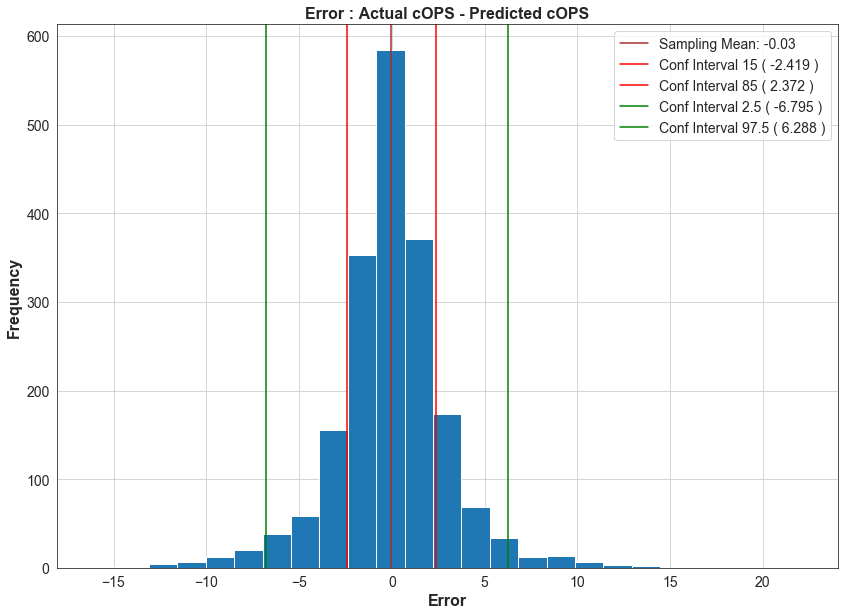

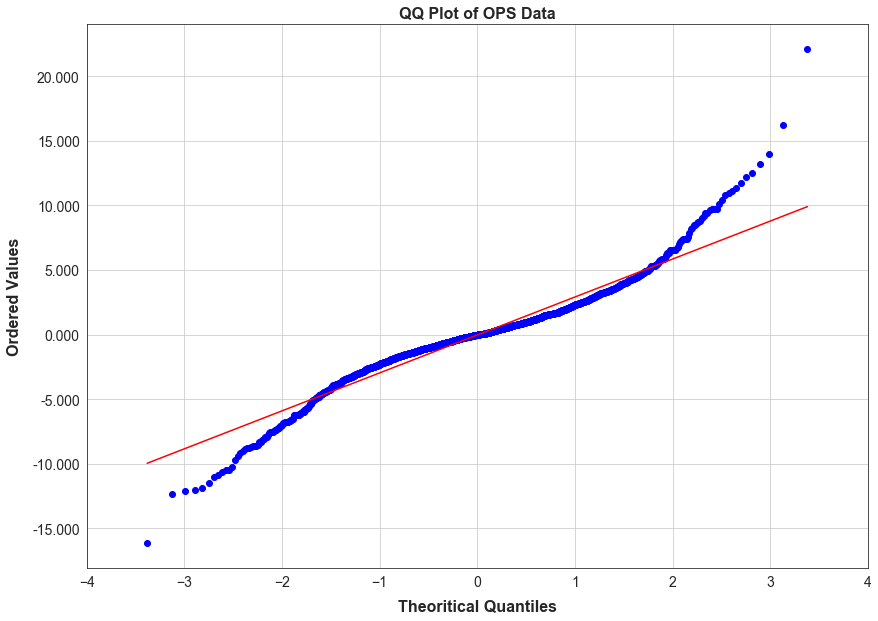

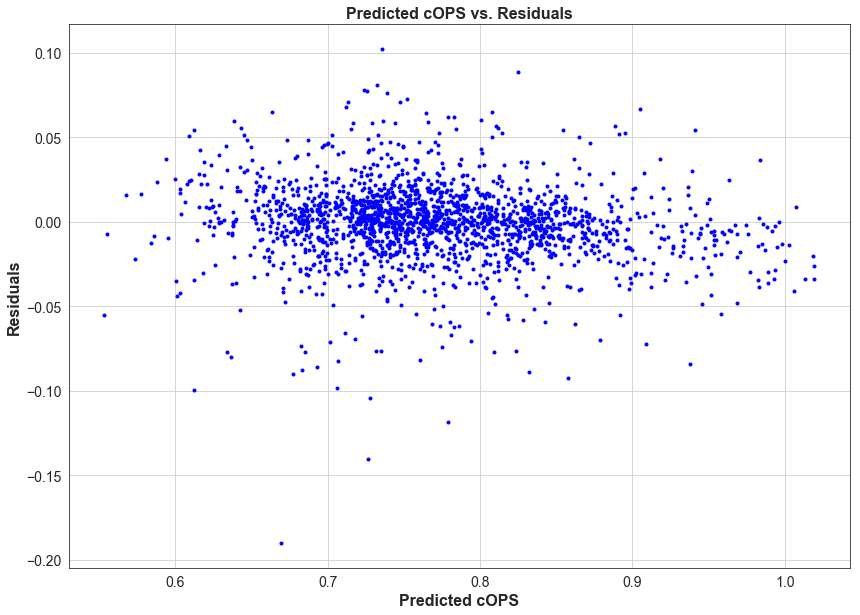

{'max_depth': 300, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 1000}


In [56]:
    print('\n')
    print('Random Forest Regressor')
    print('\n')
    # Create the parameter grid based on the results of random search 
    params = {
        'max_depth': [300],
        'max_features': [3],
        'min_samples_leaf': [5],
        'min_samples_split': [12],
        'n_estimators': [1000]
    }
    # Create a based model
    rf = RandomForestRegressor(random_state=61,bootstrap=True)
    # Instantiate the grid search model
    gs = GridSearchCV(estimator=rf,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
    gs.fit(X_train, y_train)    
    y_pred2 = gs.predict(X_train)   
    v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
    print('\n')
    print('Training Statistics: ')
    print('\n')
    print('R Squared (training): %1.3f' % v_Rsquared) 
    print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
    print('Mean Squared Error (training): %1.3f' % v_MSE)
    print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
    print('F Statistic (training): %1.3f' % v_Fstatistic)
    print('\n')
    
    print('\n')
    print('Testing Statistics: ')
    print('\n')
    y_pred = gs.predict(X_test)  
    
    lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsRF_GSc.csv',stats_list,gs)
    
    print(gs.best_params_) 

SVR is next



SVM with GridSearchCV


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.3s finished




Training Statistics: 


R Squared (training): 0.824
Adjusted R Squared (training): 0.823
Mean Squared Error (training): 0.001
Root Mean Squared Error (training): 0.033
F Statistic (training): 2265.098




Testing Statistics: 


R Squared: 0.8447
Adjusted R Squared: 0.8434
F Statistic: 646.5934
MSE: 0.0011
RMSE: 0.0332
Test Observations: 1919
Sum of Abs Pct Error: 6763.7
Pct Mean Error: -1.6009
Pct Std Dev Error: 4.2180


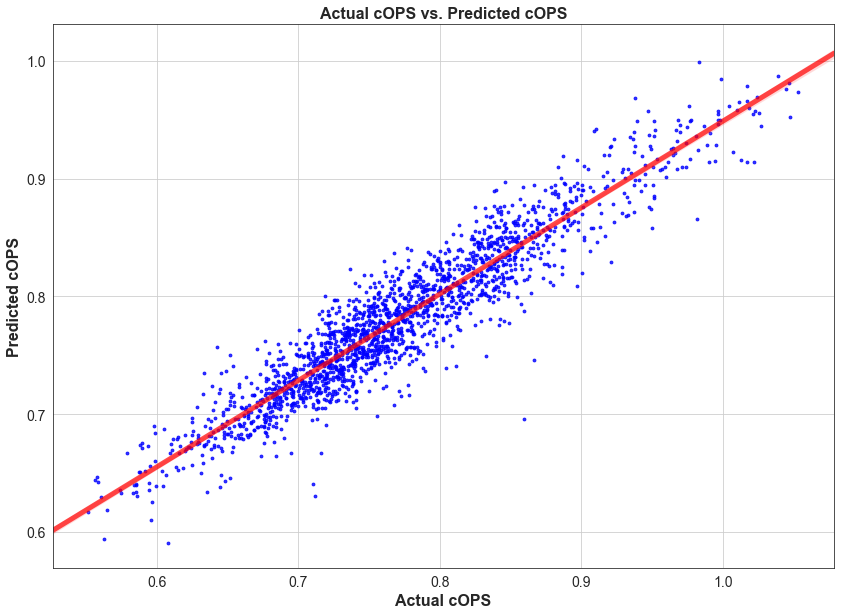

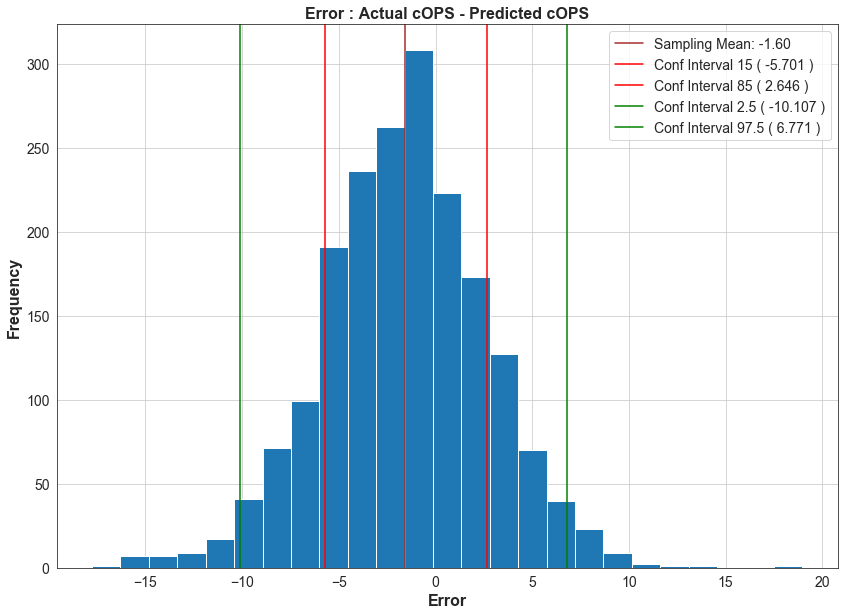

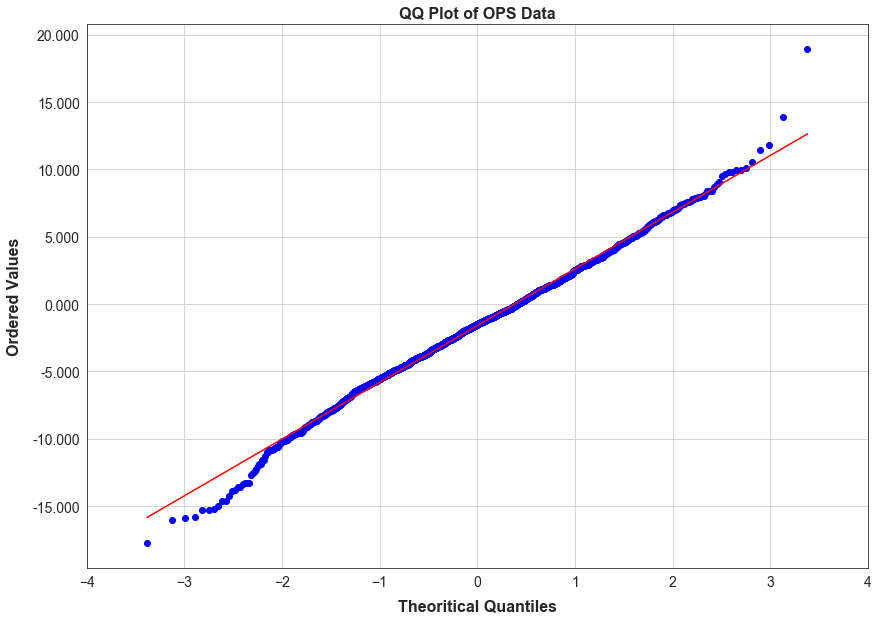

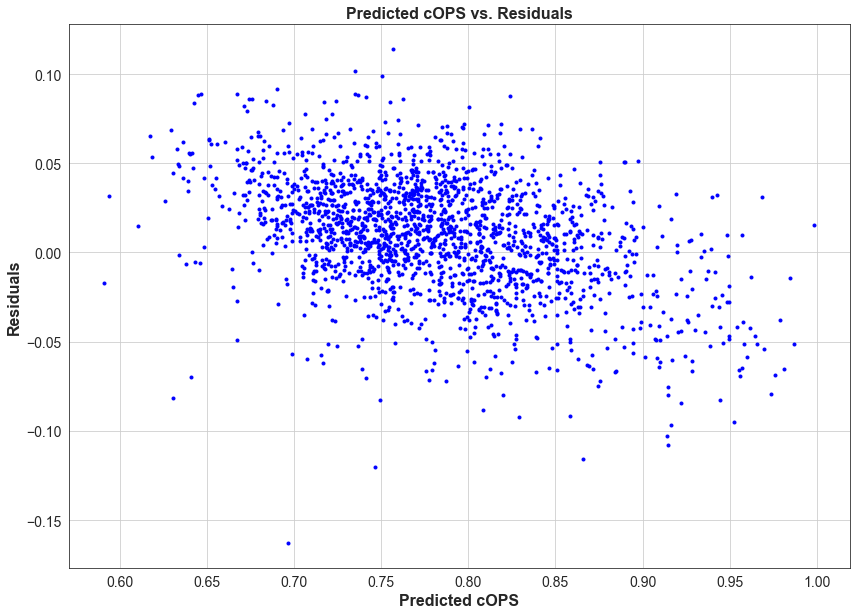

{'C': 1, 'gamma': 0.001}


In [57]:
    print('\n')
    print('SVM with GridSearchCV')
    print('\n')
    
    params = {
        'C': [0.1,1],
        'gamma': [0.001, 0.01, 0.1]
    }
    
    svm = SVR(kernel='rbf')
    
    gs = GridSearchCV(estimator=svm,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
    gs.fit(X_train, y_train)    
    y_pred2 = gs.predict(X_train)   
    v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
    print('\n')
    print('Training Statistics: ')
    print('\n')
    print('R Squared (training): %1.3f' % v_Rsquared) 
    print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
    print('Mean Squared Error (training): %1.3f' % v_MSE)
    print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
    print('F Statistic (training): %1.3f' % v_Fstatistic)
    print('\n')
    
    print('\n')
    print('Testing Statistics: ')
    print('\n')
    y_pred = gs.predict(X_test)
    
    lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsSVM_GSc.csv',stats_list,gs)
    
    print(gs.best_params_)

Last is Non-Linear Regression



Linear Regression - Polynomial


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.3s finished


R Squared: 0.9288
Adjusted R Squared: 0.9282
F Statistic: 1551.7601
MSE: 0.0005
RMSE: 0.0225
Test Observations: 1919
Sum of Abs Pct Error: 3905.2
Pct Mean Error: -0.1065
Pct Std Dev Error: 2.9773


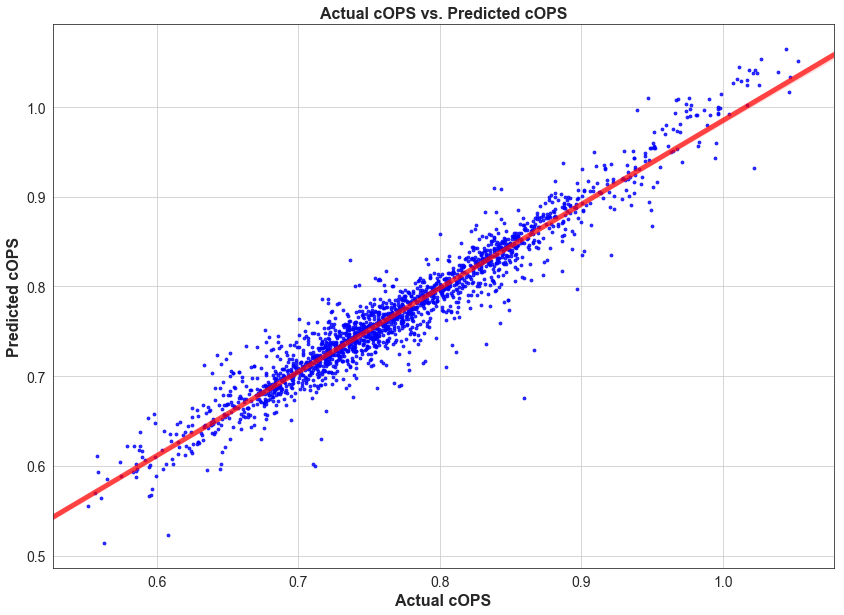

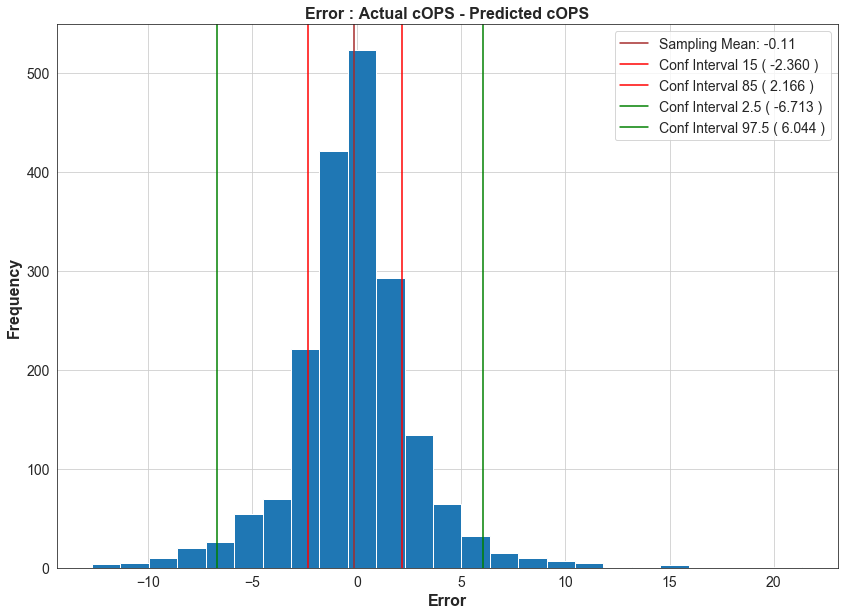

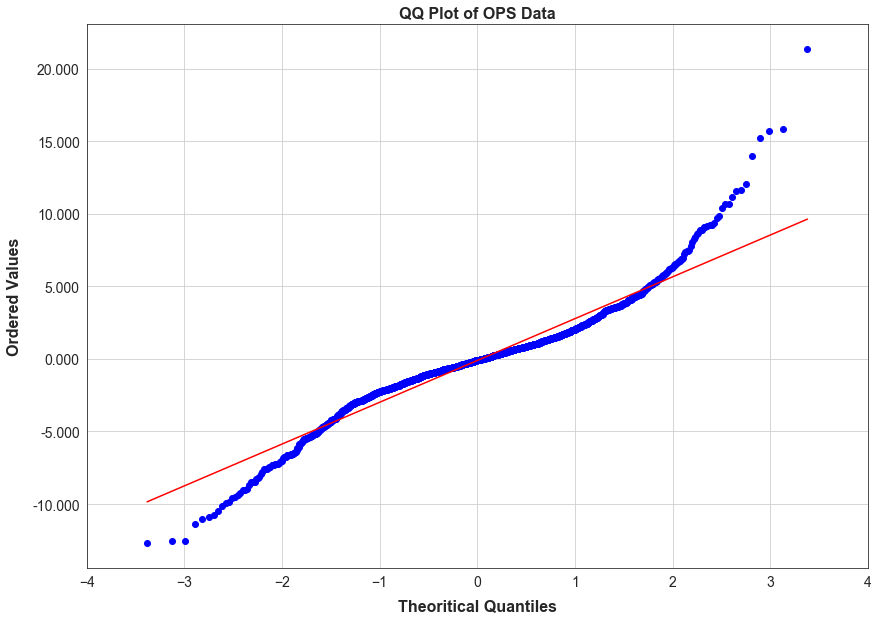

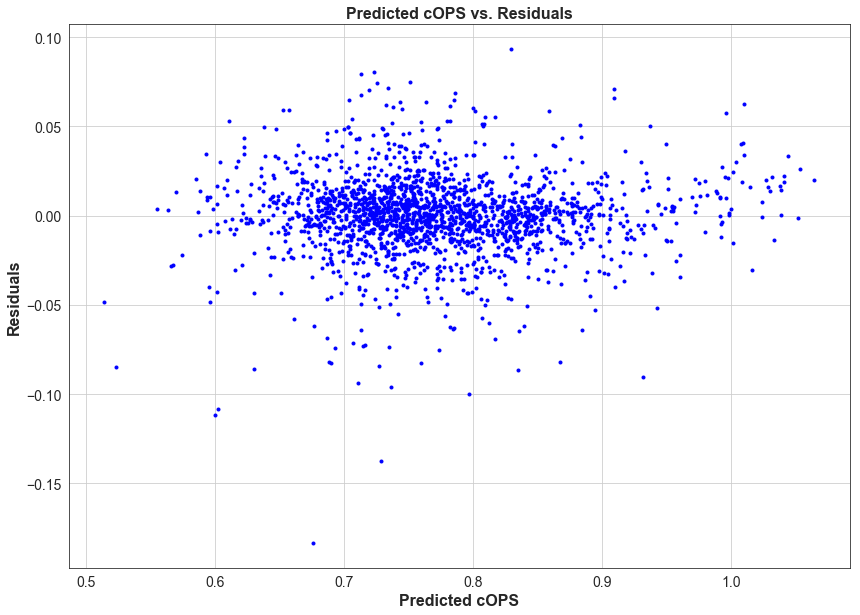

{'normalize': False}


In [58]:
    print('\n')
    print('Linear Regression - Polynomial')
    print('\n')
    
    degree = 2
    
    poly = PolynomialFeatures(degree=degree)
    X_train_ = poly.fit_transform(X_train)
    X_test_ = poly.fit_transform(X_test)
    
    lg = LinearRegression()
    
    params = {
                'normalize':[True,False]
             }
    
    gs = GridSearchCV(estimator=lg,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
    
    gs.fit(X_train_,y_train) 
    
    y_pred = gs.predict(X_test_)
    
    lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsPolyc.csv',stats_list,gs)
    
    print(gs.best_params_)

As you can see, career OPS is much easier to predict and shows excellent results.   I guess the best indicator of future performance is past performance.  Here are the scores best to last.

                                          XGBoost                 .9288
                                          Non Linear Regression   .9288
                                          Random Forests          .9257
                                          Ridge Regression        .9242
                                          SVR                     .8447

Here is a chart showing actual vs. predicted by age.

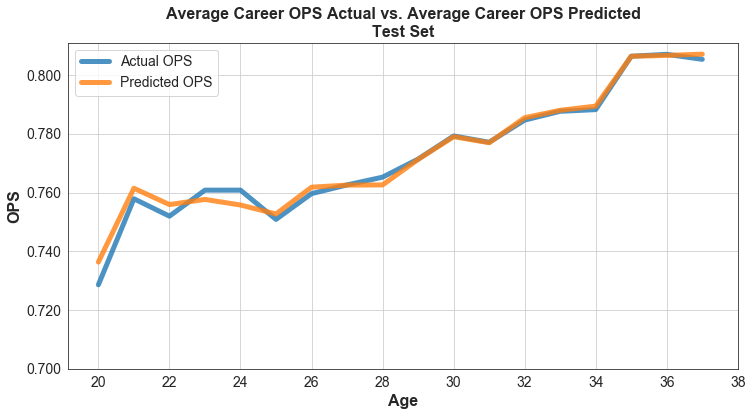

In [59]:
# plot average career actual OPS vs. average career predicted OPS
import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")

figsize(12,6)

path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'
filen = 'OPSpredictionsXGB_GSc.csv'
selectf = path + filen
df = pd.read_csv(selectf)
dfx = df.copy()
dfx = df[['age','cOPS','predcOPS']]
dfavg = df.groupby('age').mean()
dfavg = dfavg.reset_index(drop=False)

fig, ax = plt.subplots()
ax.grid()
plt.title('Average Career OPS Actual vs. Average Career OPS Predicted\nTest Set',weight='bold',size=16)
plt.xlabel('Age',weight='bold',size=16)
plt.ylabel('OPS',weight='bold',size=16)
plt.plot(dfavg.age,dfavg.cOPS,label='Actual OPS',linewidth=5,alpha=.8)
plt.plot(dfavg.age,dfavg.predcOPS,label='Predicted OPS',linewidth=5,alpha=.8)
plt.yticks(np.arange(.700,.800,.020))
plt.xticks(np.arange(20,39,2))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
leg = plt.legend(prop=dict(size=14))
plt.show()

This was as expected especially for later years of a player's career.  Note that within about 5 years, predictability is very good.  I have selected from a set of players from the 34 players whose five year predictions were made.  Below is the results of the selected players.  As you can see they are pretty close.  

Player Name:  Billy Williams
Avg Actual Career OPS 0.859
Avg Predicted Career OPS 0.834
Pct Error 2.9


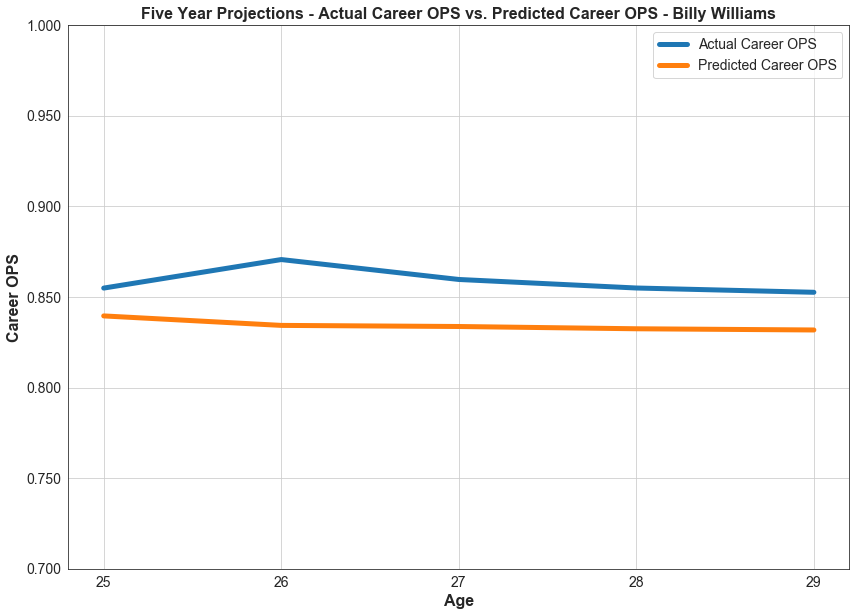

Player Name:  Lou Brock
Avg Actual Career OPS 0.763
Avg Predicted Career OPS 0.752
Pct Error 1.4


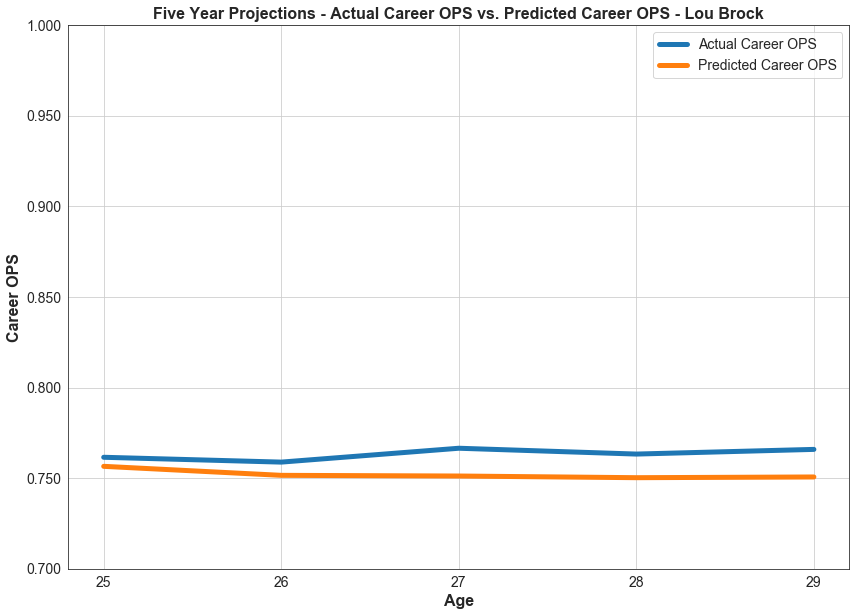

Player Name:  Jack Clark
Avg Actual Career OPS 0.840
Avg Predicted Career OPS 0.828
Pct Error 1.4


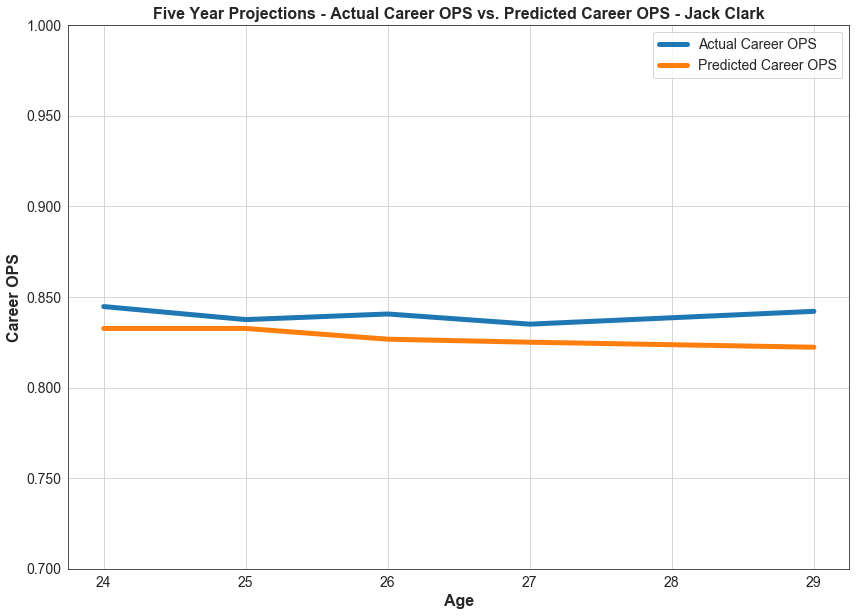

Player Name:  Joe Morgan
Avg Actual Career OPS 0.784
Avg Predicted Career OPS 0.767
Pct Error 2.2


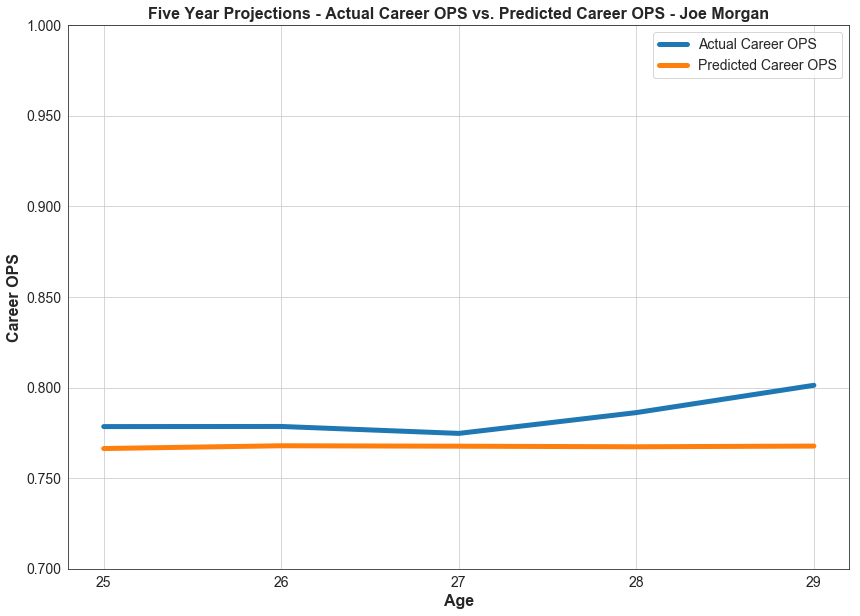

Player Name:  Joe Torre
Avg Actual Career OPS 0.829
Avg Predicted Career OPS 0.808
Pct Error 2.5


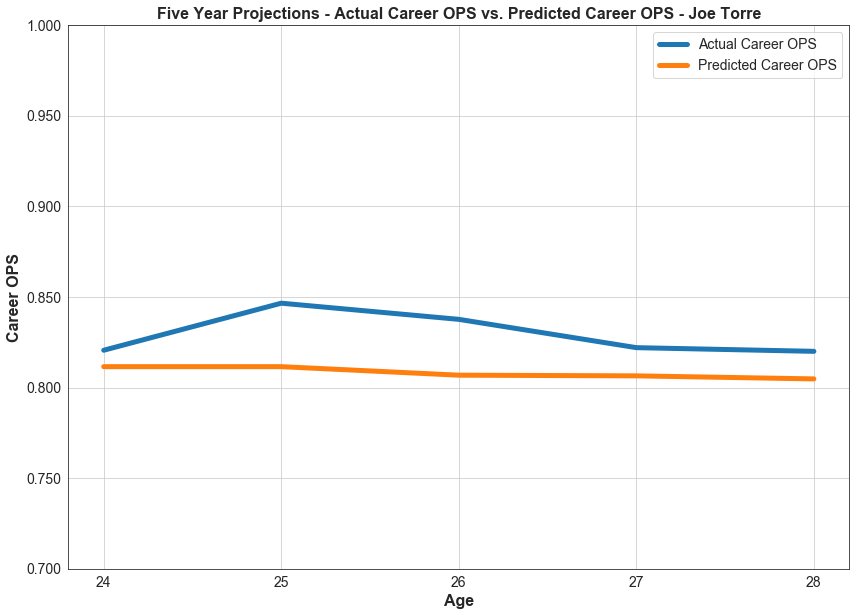

Player Name:  Paul Blair
Avg Actual Career OPS 0.722
Avg Predicted Career OPS 0.726
Pct Error -0.6


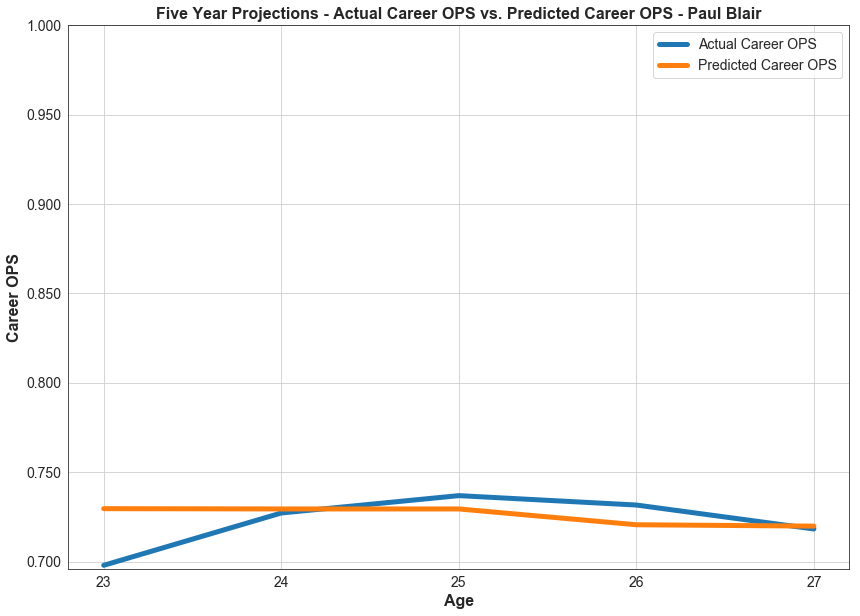

Player Name:  Rod Carew
Avg Actual Career OPS 0.774
Avg Predicted Career OPS 0.746
Pct Error 3.6


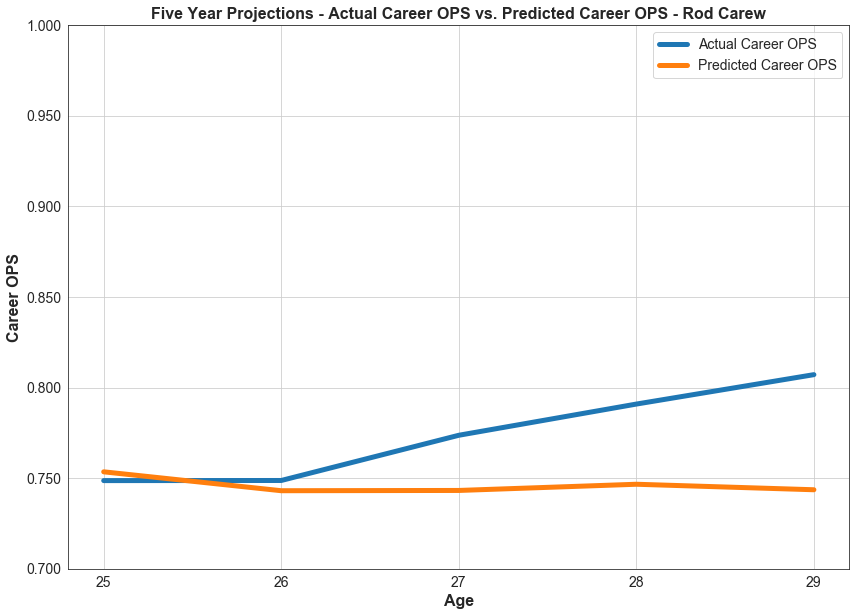

Player Name:  Ted Simmons
Avg Actual Career OPS 0.808
Avg Predicted Career OPS 0.787
Pct Error 2.6


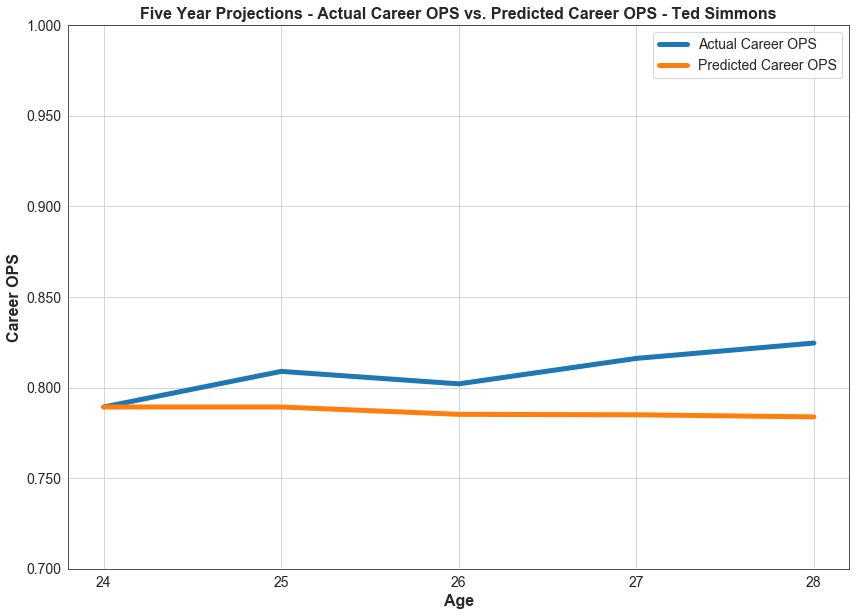

Player Name:  Mark Teixeira
Avg Actual Career OPS 0.912
Avg Predicted Career OPS 0.907
Pct Error 0.5


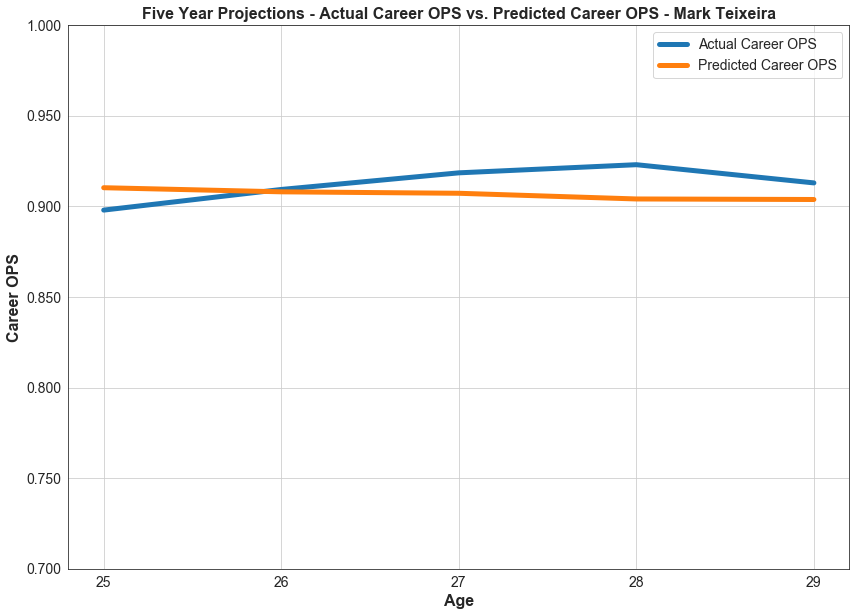

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 16 11:03:28 2019

@author: Paul Scheibal

This is a simple program which reads the output file of actual vs. predicted career OPS for the 
5 year projections which has the best R Squared value and plots age vs. OPS for the predicted ages
over 34 players.
"""

import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import matplotlib.mlab as mlab
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

figsize(14,10)
sns.set_style('white') 

# standard global constants
MIN_AT_BATS = 0
START_YEAR = 1970
END_YEAR = 2018
FSHZ = 17
START_DATE = datetime.strptime(str(START_YEAR)+'-01-01','%Y-%m-%d')
END_DATE = datetime.strptime(str(END_YEAR)+'-12-31','%Y-%m-%d')
LEGEND_PROPERTIES = {'weight':'bold'}

def plot_selected(dfx):
    pn = dfx.playername.values[0]
    print('Player Name: ',pn)
    cOPSactual = round(dfx.cOPS.mean(),3)
    cOPSpred = round(dfx.predcOPS.mean(),3)
    err = round((cOPSactual - cOPSpred) / cOPSactual * 100,1)
    print('Avg Actual Career OPS %1.3f' % cOPSactual)
    print('Avg Predicted Career OPS %1.3f' % cOPSpred)
    print('Pct Error %1.1f' % err)
    dfx.age = round(dfx.age).astype(int)
    fig, ax = plt.subplots()
    ax.grid()
    plt.plot(dfx.age,dfx.cOPS,linewidth=5,label='Actual Career OPS')
    plt.plot(dfx.age,dfx.predcOPS,linewidth=5, label='Predicted Career OPS')
    ttl = 'Five Year Projections - Actual Career OPS vs. Predicted Career OPS - ' + pn
    plt.title(ttl,weight='bold',fontsize=16)
    plt.xlabel('Age',weight='bold',fontsize=16)
    plt.ylabel('Career OPS',weight='bold',fontsize=16)
    plt.yticks(np.arange(.700,1.000,.050))
    plt.xticks(range(min(dfx.age),max(dfx.age)+1,1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
    leg=plt.legend(prop=dict(size=14))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    return True


# set path for reading Lahman baseball statistics and read data from rttm dataset
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'

playerlst = ['willibi01','brocklo01','clarkja01','morgajo02','torrejo01','blairpa01','carewro01','simmote01','teixema01']

battingf = path + 'cpOPSpredictionsXGB_GS.csv'
df = pd.read_csv(battingf)

for p in playerlst:
    dfp = df[df['playerID'] == p]
    plot_selected(dfp)
